In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%pwd
%cd drive/My Drive/MLSP/Assign5/data
%pwd

/content/drive/My Drive/MLSP/Assign5/data


'/content/drive/My Drive/MLSP/Assign5/data'

In [0]:
%ls -ltr

total 2963
-rw------- 1 root root 491505 Sep  1  2017 im8.ppm
-rw------- 1 root root 491505 Sep  1  2017 im0.ppm
-rw------- 1 root root  27118 Sep  1  2017 twitter.mat
-rw------- 1 root root 806554 Nov  3  2017 trs.wav
-rw------- 1 root root 806554 Nov  3  2017 trn.wav
-rw------- 1 root root 101626 Nov  3  2017 tex.wav
-rw------- 1 root root 101626 Nov  3  2017 tes.wav
-rw------- 1 root root   2534 Nov 12  2018 trX.mat
-rw------- 1 root root    187 Nov 12  2018 trY.mat
-rw------- 1 root root 202810 May  2 21:33 recons.wav


In [0]:
import cv2 as cv
import numpy as np
import math
import scipy.io
from scipy.io import wavfile
from scipy.io import loadmat
import random
import IPython
import librosa
import glob
import pandas as pd
import imageio
import copy
from scipy.stats import norm
from scipy.stats import multivariate_normal as mul_n
from matplotlib import pyplot as plt
from collections import OrderedDict
from collections import defaultdict
import matplotlib.patches as mpatches

# P1: Neural Network for Source Separation

In [0]:
s, sr=librosa.load('trs.wav', sr=None)
S=librosa.core.stft(s, n_fft=1024, hop_length=512)
sn, sr=librosa.load('trn.wav', sr=None)
N=librosa.core.stft(sn, n_fft=1024, hop_length=512)

In [0]:
s.shape,sn.shape

((403255,), (403255,))

In [0]:
x=s+sn
x.shape

(403255,)

In [0]:
S.shape,N.shape

((513, 788), (513, 788))

In [0]:
X=librosa.core.stft(x, n_fft=1024, hop_length=512)
X.shape

(513, 788)

In [0]:
X_abs=abs(X)
X_abs

array([[0.4235848 , 0.0101606 , 0.03536293, ..., 0.05091106, 0.03174963,
        0.0191339 ],
       [0.4257597 , 0.01430209, 0.03660645, ..., 0.03845655, 0.02509872,
        0.00569738],
       [0.5118769 , 0.06108043, 0.02913893, ..., 0.01599084, 0.01087128,
        0.01376943],
       ...,
       [0.43687406, 0.2787723 , 0.19715734, ..., 0.06153835, 0.05517702,
        0.00926899],
       [0.56207   , 0.33938777, 0.20576295, ..., 0.01873568, 0.05702251,
        0.05107136],
       [1.0034453 , 0.516791  , 0.17933339, ..., 0.0181875 , 0.00275195,
        0.09545852]], dtype=float32)

In [0]:
def IBM(S , N):

  M = np.greater(S , N) * 1
  
  return M

In [0]:
def sig_fun2(mat):
   z = 1/(1 + np.exp(-mat))
   return z

In [0]:
X_abs.shape[1]

788

In [0]:
ibm_mat = np.zeros((513,788))
ibm_mat.shape
for i in range(X_abs.shape[0]):
  for j in range(X_abs.shape[1]):
    mask = IBM(np.abs(S[i][j]) , np.abs(N[i][j]))
    ibm_mat[i][j]=mask

In [0]:
np.random.seed(600)
w1=np.random.uniform(-0.3,0.3,size=(50,513))
w2=np.random.uniform(-0.3,0.3,size=(513,50))
b1 = np.random.randn(50,1)
b2 = np.random.randn(513,1)
#w2=w2.reshape(1,3)
w1.shape,w2.shape

((50, 513), (513, 50))

In [0]:
err0=[]
acc0=[]
learning_rate=0.01
for i in range(5000):
  z1=np.matmul(w1,X_abs)+b1
  x2=np.tanh(z1)
  z2=np.matmul(w2,x2)+b2
  y_pred=sig_fun2(z2)

  bp2=(y_pred - ibm_mat)*y_pred*(1-y_pred)
  #print(bp2)
  delta_w2=np.matmul(bp2,x2.T)
  #print(delta_w2)
  
  

  bp1=np.matmul(w2.T,bp2)*(1-pow(x2,2))
  delta_w1=np.matmul(bp1,X_abs.T)
  #print(delta_w1)

  w1=w1-(learning_rate*delta_w1)
  w2=w2-(learning_rate*delta_w2)
  #print(delta_w2)
  pred_labels=np.where(y_pred >= 0.5,1,0)

  error=((y_pred-ibm_mat)**2)/2
  err0.append(np.sum(error))
  acc = np.sum(ibm_mat==pred_labels)/(ibm_mat.shape[1]*ibm_mat.shape[0])
  acc0.append(acc)
  #acc0.append(np.equal(np.where(y_pred >= 0.5,1,0),t).sum()/152)

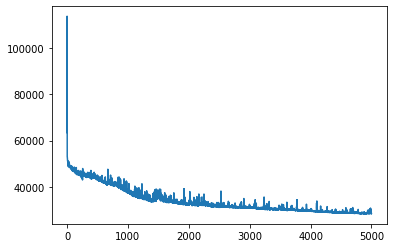

In [0]:
plt.plot(err0)

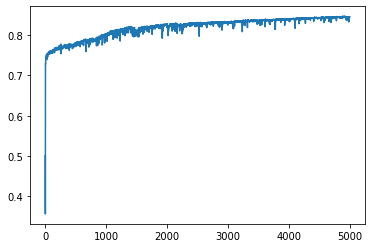

In [0]:
plt.plot(acc0)

In [0]:
s1, sr1=librosa.load('tes.wav', sr=None)
S_t=librosa.core.stft(s1, n_fft=1024, hop_length=512)
sn1, sr1=librosa.load('tex.wav', sr=None)
N_t=librosa.core.stft(sn1, n_fft=1024, hop_length=512)

In [0]:
  z1=np.matmul(w1,np.abs(N_t))
  x2=np.tanh(z1)
  z2=np.matmul(w2,x2)
  y_t_pred=sig_fun2(z2)
  pred_t_labels=np.where(y_t_pred >= 0.5,1,0)

In [0]:
  s_bar=np.multiply(N_t,pred_t_labels)
  S_recon1=librosa.istft(s_bar,hop_length=512)
  #pred_t_labels.shape,N_t.shape

In [0]:
size = np.shape(S_recon1)[0]
s1 = s1[: size]
SNR = 10 * np.log10(np.add.reduce(s1**2, axis = None) / np.add.reduce((s1-S_recon1)**2, axis =None))
print(SNR)

6.1602383852005005


In [0]:
librosa.output.write_wav('recons.wav', S_recon1, sr1)
IPython.display.Audio("recons.wav")

# P2: Stereo Matching (revisited)

In [0]:
X_L = imageio.imread('im0.ppm')
X_R = imageio.imread('im8.ppm')
X_L.shape,X_R.shape

((381, 430, 3), (381, 430, 3))

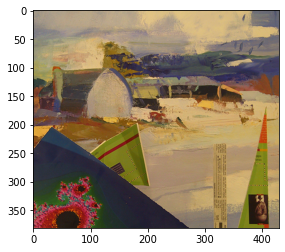

In [0]:
plt.imshow(X_L)

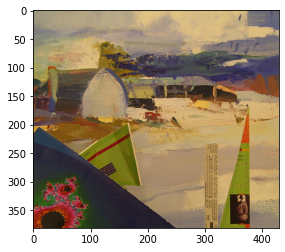

In [0]:
plt.imshow(X_R)

In [0]:
def diparity_map(first_image,second_image,window):
  disparity=[]
  for row in range(first_image.shape[0]):
    for col in range(first_image.shape[1] - window):
        min_dist = np.sum(((second_image[row, col, :] - first_image[row, col, :])**2))
        min_idx = 0
        for col_idx in range(window):
            dist = np.sum(((second_image[row, col, :] - first_image[row, (col + col_idx), :])**2))
            if(dist < min_dist):
                min_dist = dist
                min_idx = col_idx
        disparity.append(min_idx)
  return disparity       


In [0]:
D=diparity_map(X_L,X_R,40)
D=np.array(D)
D=D.reshape(381,390)
D.shape

(381, 390)

Text(0.5, 1.0, 'Histogram of disparity matrix')

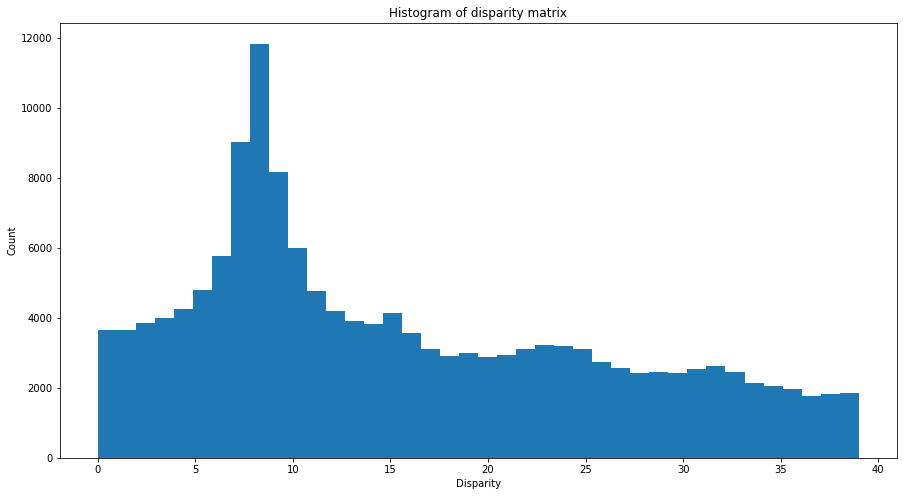

In [0]:
plt.figure(figsize=(15, 8))
plt.hist(D.reshape(-1), bins = 40)
plt.xlabel('Disparity')
plt.ylabel('Count')
plt.title('Histogram of disparity matrix')

It looks like there are 4 clusters as theres are 4 peaks.

In [0]:
disparity=D.reshape(-1)
disparity.shape

(148590,)

In [0]:
cluster_idx1=random.randint(0,148590)
cluster_idx2=random.randint(0,148590)
cluster_idx3=random.randint(0,148590)
cluster_idx4=random.randint(0,148590)
cluster_mean1=disparity[cluster_idx1]
cluster_mean2=disparity[cluster_idx2]
cluster_mean3=disparity[cluster_idx3]
cluster_mean4=disparity[cluster_idx4]
cm1,cm2,cm3,cm4=cluster_mean1,cluster_mean2,cluster_mean3,cluster_mean4
cluster_mean1,cluster_mean2,cluster_mean3,cluster_mean4

(36, 15, 8, 17)

In [0]:
for _ in range(5):
  cluster1=[]
  cluster2=[]
  cluster3=[]
  cluster4=[]
  for i in range(148590):
    d1=abs(cluster_mean1-disparity[i])
    d2=abs(cluster_mean2-disparity[i])
    d3=abs(cluster_mean3-disparity[i])
    d4=abs(cluster_mean4-disparity[i])
    if (d1<d2):
      if(d1<d3):
        if(d1<d4): 
          cluster1.append(disparity[i])
        else:
          cluster4.append(disparity[i])
      else:
        if (d3<d4):
          cluster3.append(disparity[i])
        else:
          cluster4.append(disparity[i])  
    else:
      if (d2<d3):
        if (d2<d4):
          cluster2.append(disparity[i])
        else:
          cluster4.append(disparity[i])
      else:
        if(d3<d4):
          cluster3.append(disparity[i])  
        else:
          cluster4.append(disparity[i])      

          
  cluster_mean1=np.mean(cluster1)
  cluster_mean2=np.mean(cluster2)   
  cluster_mean3=np.mean(cluster3)
  cluster_mean4=np.mean(cluster4)   



In [0]:
cluster_mean1,cluster_mean2,cluster_mean3,cluster_mean4

(33.09663437982889, 13.104052802914913, 5.599124474005701, 22.456812200553344)

In [0]:
for _ in range(5):
  cluster1=[]
  cluster2=[]
  cluster3=[]
  cluster4=[]
  distance1=[]
  distance2=[]
  distance3=[]
  distance4=[]
  mem1=[]
  mem2=[]
  mem3=[]
  mem4=[]
  s1=0
  s2=0
  s3=0
  s4=0
  for i in range(148590):
    d1=(cm1-disparity[i])**2
    d2=(cm2-disparity[i])**2
    d3=(cm3-disparity[i])**2
    d4=(cm4-disparity[i])**2
    distance1.append(d1)
    distance2.append(d2)
    distance3.append(d3)
    distance4.append(d4)
    if (d1<d2):
      if(d1<d3):
        if(d1<d4): 
          cluster1.append(disparity[i])
          s1+=disparity[i]
          cluster2.append(0)
          cluster3.append(0)
          cluster4.append(0)
          mem1.append(1)
          mem2.append(0)
          mem3.append(0)
          mem4.append(0)
        else:
          cluster4.append(disparity[i])
          s4+=disparity[i]
          cluster1.append(0)
          cluster2.append(0)
          cluster3.append(0)
          mem4.append(1)
          mem2.append(0)
          mem3.append(0)
          mem1.append(0)
      else:
        if (d3<d4):
          cluster3.append(disparity[i])
          s3+=disparity[i]
          cluster2.append(0)
          cluster1.append(0)
          cluster4.append(0)
          mem3.append(1)
          mem2.append(0)
          mem1.append(0)
          mem4.append(0)
        else:
          cluster4.append(disparity[i])
          s4+=disparity[i]
          cluster2.append(0)
          cluster3.append(0)
          cluster1.append(0)
          mem4.append(1)
          mem2.append(0)
          mem3.append(0)
          mem1.append(0)  
    else:
      if (d2<d3):
        if (d2<d4):
          cluster2.append(disparity[i])
          s2+=disparity[i]
          cluster1.append(0)
          cluster3.append(0)
          cluster4.append(0)
          mem2.append(1)
          mem1.append(0)
          mem3.append(0)
          mem4.append(0)
        else:
          cluster4.append(disparity[i])
          s4+=disparity[i]
          cluster2.append(0)
          cluster3.append(0)
          cluster1.append(0)
          mem4.append(1)
          mem2.append(0)
          mem3.append(0)
          mem1.append(0)
      else:
        if(d3<d4):
          cluster3.append(disparity[i])
          s3+=disparity[i]
          cluster2.append(0)
          cluster1.append(0)
          cluster4.append(0)
          mem3.append(1)
          mem2.append(0)
          mem1.append(0)
          mem4.append(0)  
        else:
          cluster4.append(disparity[i])
          s4+=disparity[i]
          cluster2.append(0)
          cluster3.append(0)
          cluster1.append(0)
          mem4.append(1)
          mem2.append(0)
          mem3.append(0)
          mem1.append(0)   
  cm1=s1/sum(mem1)
  cm2=s2/sum(mem2)
  cm3=s3/sum(mem3)
  cm4=s4/sum(mem4)
  

In [0]:
membership_matrix=np.zeros(shape =(len(mem1),4))
membership_matrix[:,0]=mem1
membership_matrix[:,1]=mem2
membership_matrix[:,2]=mem3
membership_matrix[:,3]=mem4
membership_matrix.shape

(148590, 4)

In [0]:
distance_matrix=np.zeros(shape =(len(distance1),4))
distance_matrix[:,0]=distance1
distance_matrix[:,1]=distance2
distance_matrix[:,2]=distance3
distance_matrix[:,3]=distance4
distance_matrix.shape

(148590, 4)

In [0]:
cluster_matrix=np.zeros(shape =(len(cluster1),4))
cluster_matrix[:,0]=cluster1
cluster_matrix[:,1]=cluster2
cluster_matrix[:,2]=cluster3
cluster_matrix[:,3]=cluster4
cluster_matrix.shape

(148590, 4)

In [0]:
distance_matrix

array([[9.67000670e+02, 1.23299989e+02, 1.29536970e+01, 4.18481165e+02],
       [6.81034326e+02, 3.72594606e+01, 1.96245224e+00, 2.38913043e+02],
       [3.64681445e+02, 8.02721380e-01, 7.05747096e+01, 7.15176726e+01],
       ...,
       [3.71689508e+01, 1.93097349e+02, 4.57997473e+02, 2.06405554e+01],
       [1.20260696e+00, 3.57056820e+02, 6.97006229e+02, 9.10724334e+01],
       [8.46614132e+02, 8.28837774e+01, 2.55719908e+00, 3.40653917e+02]])

In [0]:
cluster_matrix

array([[ 0.,  0.,  2.,  0.],
       [ 0.,  0.,  7.,  0.],
       [ 0., 14.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., 27.],
       [32.,  0.,  0.,  0.],
       [ 0.,  0.,  4.,  0.]])

In [0]:
k_means = np.array([cm1,cm2,cm3,cm4])
k_means = k_means.reshape(k_means.shape[0],1)
k_means

array([[33.09663438],
       [13.1040528 ],
       [ 5.59912447],
       [22.4568122 ]])

In [0]:
std=np.array([np.std(cluster1),np.std(cluster2),np.std(cluster3),np.std(cluster4)])
std = std.reshape(std.shape[0],1)
std1,std2,std3,std4=np.std(cluster1),np.std(cluster2),np.std(cluster3),np.std(cluster4)
std1,std2,std3,std4

(12.755796196847818, 5.583859869321279, 3.25777193670135, 9.060894134970555)

In [0]:
ini_means=k_means
ini_means1,ini_means2,ini_means3,ini_means4=k_means[0][0],k_means[1][0],k_means[2][0],k_means[3][0]
ini_means1,ini_means2,ini_means3,ini_means4

(33.09663437982889, 13.104052802914913, 5.599124474005701, 22.456812200553344)

In [0]:
sum(mem1),sum(mem2),sum(mem3),sum(mem4)

(26533, 33483, 58936, 29638)

In [0]:
p1 = sum(mem1) / (sum(mem1) + sum(mem2)+ sum(mem3)+ sum(mem4))
p2 = sum(mem2) / (sum(mem1) + sum(mem2)+ sum(mem3)+ sum(mem4))
p3 = sum(mem3) / (sum(mem1) + sum(mem2)+ sum(mem3)+ sum(mem4))
p4 = sum(mem4) / (sum(mem1) + sum(mem2)+ sum(mem3)+ sum(mem4))
p1,p2,p3,p4

(0.17856517935258093,
 0.22533817888148597,
 0.39663503600511474,
 0.19946160576081837)

In [0]:
membership_mat=membership_matrix

In [0]:
disparity=disparity.reshape(disparity.shape[0],1)
membership_mat.shape,disparity.shape

((148590, 4), (148590, 1))

In [0]:
def pdf(num,mean,stand_dev):
  denom = 1 / (stand_dev * np.sqrt(2 * np.pi))
  d = np.exp(-((num - mean)**2/(2*(stand_dev**2))))
  return(d*denom)

In [0]:
for _ in range(30):
    #E-Step
    for i in range(148590):
      d1=p1*pdf(disparity[i],ini_means1,std1)
      d2=p2*pdf(disparity[i],ini_means2,std2)
      d3=p3*pdf(disparity[i],ini_means3,std3)
      d4=p4*pdf(disparity[i],ini_means4,std4)
      membership_mat[i][0]=d1/(d1+d2+d3+d4)
      membership_mat[i][1]=d2/(d1+d2+d3+d4)
      membership_mat[i][2]=d3/(d1+d2+d3+d4)
      membership_mat[i][3]=d4/(d1+d2+d3+d4)
    #M-Step
    sum1 = 0
    sum2 = 0
    sum3 = 0
    sum4 = 0
    counter1 = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    for i in range(148590):
      sum1+=membership_mat[i][0] * disparity[i]
      sum2+=membership_mat[i][1] * disparity[i]
      sum3+=membership_mat[i][2] * disparity[i]
      sum4+=membership_mat[i][3] * disparity[i]
      counter1+=membership_mat[i][0]
      counter2+=membership_mat[i][1]
      counter3+=membership_mat[i][2]
      counter4+=membership_mat[i][3]

    ini_means1 = sum1/counter1
    ini_means2 = sum2/counter2
    ini_means3 = sum3/counter3
    ini_means4 = sum4/counter4
    #print(ini_means1, ini_means2)

    p1 = counter1 / 148590
    p2 = counter2 / 148590
    p3 = counter3 / 148590
    p4 = counter4 / 148590

    new_sum1 = 0
    new_sum2 = 0
    new_sum3 = 0
    new_sum4 = 0
    for i in range(148590):
      new_sum1 = new_sum1 + membership_mat[i][0]*((disparity[i] - ini_means1)**2)
      new_sum2 = new_sum2 + membership_mat[i][1]*((disparity[i] - ini_means2)**2)
      new_sum3 = new_sum3 + membership_mat[i][2]*((disparity[i] - ini_means3)**2)
      new_sum4 = new_sum4 + membership_mat[i][3]*((disparity[i] - ini_means4)**2)

    std1 = new_sum1 / counter1
    std1 = np.sqrt(std1)
    std2 = new_sum2 / counter2
    std2 = np.sqrt(std2)
    std3 = new_sum3 / counter3
    std3 = np.sqrt(std3)
    std4 = new_sum4 / counter4
    std4 = np.sqrt(std4)


#print(ini_means1, ini_means2)

In [0]:
gmm_means=np.array([ini_means1,ini_means2,ini_means3,ini_means4])
gmm_means

array([[32.57704093],
       [13.63791767],
       [ 6.56113612],
       [22.43353776]])

In [0]:
std=np.array([std1,std2,std3,std4])
var=std**2
var

array([[17.85808755],
       [31.79702405],
       [12.59669591],
       [37.69849947]])

In [0]:
P=np.array([p1,p2,p3,p4])
P

array([0.15755023, 0.2131527 , 0.41543859, 0.21385848])

In [0]:
predictions = np.argmax(membership_mat,axis = 1)

In [0]:
predictiedLabels = predictions.reshape((381,390))

In [0]:
predictiedLabels

array([[2, 2, 1, ..., 2, 1, 2],
       [2, 2, 2, ..., 3, 2, 2],
       [2, 2, 2, ..., 0, 0, 2],
       ...,
       [1, 3, 1, ..., 0, 0, 3],
       [0, 0, 2, ..., 0, 0, 0],
       [3, 0, 0, ..., 3, 0, 2]])

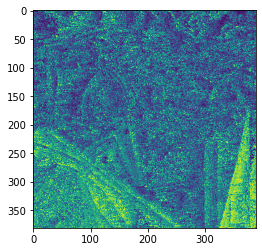

In [0]:
plt.imshow(D)

In [0]:
disp1 = disparity.astype(np.float16).reshape(381,390).copy()
class_map = disparity.reshape(381,390).copy()
for i, mean in enumerate(gmm_means): 
  class_map[predictiedLabels==i] = i
  disp1[predictiedLabels==i] = mean

In [0]:
disp1

array([[ 6.562,  6.562, 13.64 , ...,  6.562, 13.64 ,  6.562],
       [ 6.562,  6.562,  6.562, ..., 22.44 ,  6.562,  6.562],
       [ 6.562,  6.562,  6.562, ..., 32.56 , 32.56 ,  6.562],
       ...,
       [13.64 , 22.44 , 13.64 , ..., 32.56 , 32.56 , 22.44 ],
       [32.56 , 32.56 ,  6.562, ..., 32.56 , 32.56 , 32.56 ],
       [22.44 , 32.56 , 32.56 , ..., 22.44 , 32.56 ,  6.562]],
      dtype=float16)

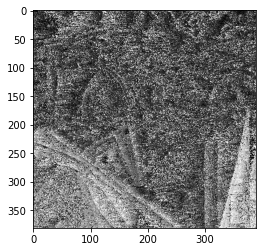

In [0]:
plt.imshow(disparity.reshape(381,390),cmap = 'gray') 

In [0]:
def expected_value(disparity, prob, i, j):
    alpha = 5
    sigma = 1
    if(disparity[i,j] == prob):
        return 0
    else:
        return -1 * alpha**2/sigma**2

In [0]:
def likelyhood(disparity,prob):
  nor=norm(gmm_means[prob],std[prob])
  return nor.pdf(disparity)

In [0]:
#MRF with ICM
mrf_matrix1=copy.deepcopy(disp1)
for _ in range(2):
  i = np.random.randint(0,disp1.shape[0])
  j = np.random.randint(0,disp1.shape[1])
  bfs=[(i,j)]
  track={(i,j):True}
  count = 0 # 381*390
  while bfs:
      prob_vector = []
      (i,j)=bfs.pop(0)
      #print(i,j)
      for prob in range(len(P)):
          res=likelyhood(mrf_matrix1[i,j],prob)
          for n in [(i-1, j-1),(i-1, j),(i-1,j +1), (i, j-1), (i, j+1), (i+1, j-1), (i+1, j), (i+1, j+1)]:
            if(n[0] >=0 and n[1] >= 0 and n[0] < mrf_matrix1.shape[0] and n[1] < mrf_matrix1.shape[1]):
                res = res*np.exp(expected_value(class_map, prob, n[0], n[1]))
                #res=res*likelyhood(mrf_matrix1[n[0],n[1]],class_map[n[0],n[1]])
                if n not in track:
                    bfs.append(n)
                    track[n]=True 
          prob_vector.append(res)          
      class_map[i, j] = np.argmax(prob_vector)
      mrf_matrix1[i,j]=gmm_means[class_map[i,j]]
      count+=1
      if count%10000==0:
        print('count',count)       


count 10000
count 20000
count 30000
count 40000
count 50000
count 60000
count 70000
count 80000
count 90000
count 100000
count 110000
count 120000
count 130000
count 140000
count 10000
count 20000
count 30000
count 40000
count 50000
count 60000
count 70000
count 80000
count 90000
count 100000
count 110000
count 120000
count 130000
count 140000


In [0]:
class_map1=copy.deepcopy(class_map)

In [0]:
for i, mean in enumerate(gmm_means): 
  class_map1[class_map==i] = mean

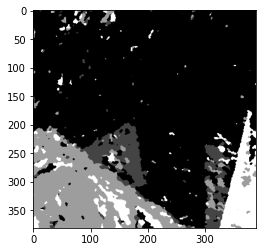

In [0]:
#MRF plot
plt.imshow(class_map1, cmap="gray")

# P3: Rock or Metal

In [0]:
trX=loadmat('trX.mat')['trX']
trX.shape

(2, 160)

In [0]:
trY=loadmat('trY.mat')['trY']
trY.shape

(1, 160)

In [0]:
trX=np.append(trX,[1]*160)
trX=trX.reshape(3,160)
trX.shape

(3, 160)

In [0]:
#err=[]
#acc=[]
def perceptron_layer(w_t,W,X,t):
  learning_rate=1e-3
  for i in range(500):
    z1=np.matmul(W,X)
    y_pred=np.tanh(z1)
    bp=np.multiply(((y_pred - t)*(1-pow(y_pred,2))),w_t)
    delta_w=np.matmul(bp,(X.T))
    W=W-(learning_rate*delta_w)
    #print(W.shape,((t-y_pred)**2).shape)
    error=w_t*((t-y_pred)**2)
    error=np.sum(error)
    acc=np.sum(trY==np.sign(y_pred))/trY.shape[1]
  #print('Final accurary',acc)  
  return W,np.sign(y_pred) 

In [0]:
def adaboost(X,Y,num_weak_learners):
  w_list=[]
  y_pred_list=[]
  beta_list=[]
  W_obs=np.ones(trY.shape[1])
  for i in range(num_weak_learners):
    W=np.random.uniform(size=(1,3))
    w,y=perceptron_layer(W_obs,W,X,Y)
    #print(y.shape)
    num  = np.sum(W_obs[trY[0] ==y[0]])
    denom = np.sum(W_obs[trY[0] !=y[0]])
    beta = 0.5*np.log(num/denom)
    W_obs = W_obs*np.exp(-beta*y*trY)[0]
    w_list.append(w)
    y_pred_list.append(y)
    beta_list.append(beta)
  return w_list,y_pred_list,beta_list,W_obs

In [0]:
w_list,y_pred_list,beta_list,W_obs=adaboost(trX,trY,2000)

In [0]:
finalPredictionMat = np.array(y_pred_list)[:,0,:]*np.array(beta_list)[:,np.newaxis]
finalPredictions = np.sign(np.sum(finalPredictionMat,axis = 0))

In [0]:
print('Accuracy for train data',np.sum(trY==finalPredictions)/trY.shape[1])

Accuracy for train data 0.9875


In [0]:
def feed_forward(w_list,beta_list,teX):
  test_pred=[]
  teX = np.concatenate((teX,np.ones((1,teX.shape[1]))))
  for w in w_list:
    #print(w.shape,teX.shape)
    z1=np.matmul(w,teX)
    y_pred=np.tanh(z1)
    test_pred.append(np.sign(y_pred))
  test_finalPredictionMat = np.array(test_pred)[:,0,:]*np.array(beta_list)[:,np.newaxis]
  test_finalPredictions = np.sign(np.sum(test_finalPredictionMat,axis = 0))  
  return test_finalPredictions  

In [0]:
x_lower, x_higher = trX[0, :].min()-0.01, trX[0, :].max()+0.01
y_lower, y_higher = trX[1, :].min()-0.01, trX[1, :].max()+0.01
x, y = np.meshgrid(np.arange(x_lower, x_higher, 0.01),
                     np.arange(y_lower, y_higher, 0.01))

x_cont = np.array([x.ravel(),y.ravel()])
x_cont_preds =feed_forward(w_list,beta_list,x_cont)

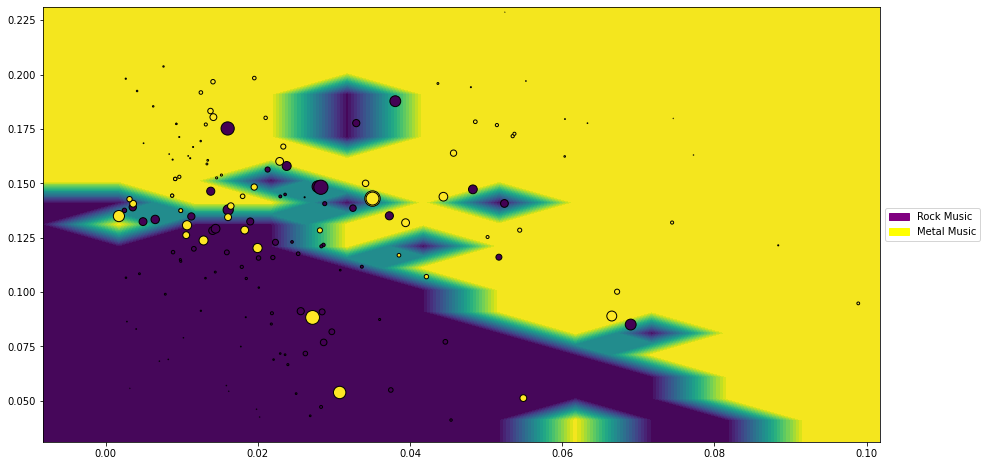

In [0]:
purple_patch = mpatches.Patch(color='purple', label='Rock Music')
yellow_patch = mpatches.Patch(color='yellow', label='Metal Music')
f, ax = plt.subplots(figsize=(15, 8))
x_cont_preds = x_cont_preds.reshape(x.shape)
ax.contourf(x, y, x_cont_preds,30,cmap='viridis')
ax.scatter(trX[0, :], trX[1, :], c=finalPredictions,s = W_obs*200,cmap='viridis',edgecolor="black",linewidth=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=[purple_patch,yellow_patch])
ax.set(aspect="auto")
plt.show()

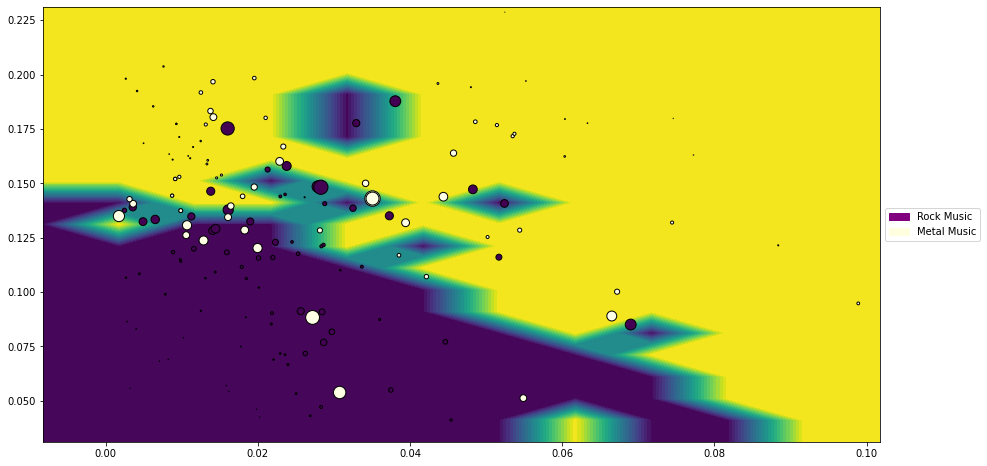

In [0]:
idx_r=[]
idx_m=[]
for i in range(len(finalPredictions)):
  if finalPredictions[i]==-1:
    idx_r.append(i)
  else:
    idx_m.append(i)  

f_r=[]
f_m=[]
for i in idx_r:
    f_r.append(finalPredictions[i])

for i in idx_m:
    f_m.append(finalPredictions[i])  

W_obs_r=[]
W_obs_m=[]
for i in idx_r:
  W_obs_r.append(W_obs[i])
for i in idx_m:
  W_obs_m.append(W_obs[i])  

trX_r_0=[]
trX_m_0=[]
trX_r_1=[]
trX_m_1=[]
for i in idx_r:
  trX_r_0.append(trX[0,i])
  trX_r_1.append(trX[1,i])
for i in idx_m:
  trX_m_0.append(trX[0,i])
  trX_m_1.append(trX[1,i]) 

W_obs_r=np.dot(W_obs_r,200)  
W_obs_m=np.dot(W_obs_m,200)


violet_patch = mpatches.Patch(color='purple', label='Rock Music')
yellow_patch = mpatches.Patch(color='lightyellow', label='Metal Music')
f, ax = plt.subplots(figsize=(15, 8))
x_cont_preds = x_cont_preds.reshape(x.shape)
ax.contourf(x, y, x_cont_preds,30,cmap='viridis')
ax.scatter(trX_r_0, trX_r_1, c=f_r,s = W_obs_r,cmap='viridis',edgecolor="black",linewidth=1)
ax.scatter(trX_m_0, trX_m_1, c=f_m,s = W_obs_m,cmap='YlGn',edgecolor="black",linewidth=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),handles=[violet_patch,yellow_patch])
ax.set(aspect="auto")
plt.show()



# P4: PLSI for Analyzing Twitter Stream

In [0]:
data=loadmat('twitter.mat')

In [0]:
X_tr=data['Xtr']
X_te=data['Xte']
Y_tr=data['YtrMat']
Y_te=data['YteMat']

In [0]:
X_tr.shape,Y_tr.shape,X_te.shape,Y_te.shape

((891, 773), (3, 773), (891, 193), (3, 193))

In [0]:
def softmax(input):
    return np.exp(input) / np.sum(np.exp(input),axis = 0)

In [0]:
def calculate_plsi(input,topic_size,if_train,B=None):
  row=input.shape[0]
  col=input.shape[1]
  theta=np.random.randn(topic_size,col)
  bias=1e-300
  init_mat_B=np.ones((row,row))

  if if_train==True:
    B=np.random.randn(row,topic_size)
    for i in range(300):
            delta = input/(np.matmul(B,theta)+bias)
            delta_B =np.matmul(delta,theta.T)
            B=np.multiply(B,delta_B)
            delta_theta = np.matmul(B.T,delta)
            theta=np.multiply(theta,delta_theta)
            B_denom=np.matmul(init_mat_B,B)+bias
            B = B/B_denom
            theta_denom=np.matmul(np.ones((topic_size,topic_size)),theta) + bias
            theta = theta/theta_denom
  else:
    for i in range(300):
            delta = input/(np.matmul(B,theta)+bias)
            delta_theta = np.matmul(B.T,delta)
            theta=np.multiply(theta,delta_theta)
            theta_denom=np.matmul(np.ones((topic_size,topic_size)),theta) + bias
            theta = theta/theta_denom
  return B,theta          

In [0]:
B_tr,theta_tr = calculate_plsi(X_tr,50,True)

In [0]:
B_te,theta_te = calculate_plsi(X_te,50,False,B_tr)

In [0]:
theta_tr=np.append(theta_tr,[1]*773)
theta_tr=theta_tr.reshape(51,773)
theta_tr.shape

(51, 773)

In [0]:
#weight_mat= np.random.randn(3, 51)
weight_mat=np.random.uniform(-0.3,0.3,size=(3,51))
weight_mat.shape

(3, 51)

In [0]:
weight_mat.shape,theta_tr.shape

((3, 51), (51, 773))

In [0]:
err=[]
acc=[]
learning_rate=1e-1
for i in range(5000):
  z1=np.matmul(weight_mat,theta_tr)
  y_pred=softmax(z1)
  bp=(y_pred - Y_tr)
  delta_w=np.matmul(bp,(theta_tr.T))
  weight_mat=weight_mat-(learning_rate*delta_w)
  error=((y_pred-Y_tr)**2)/2
  err.append(np.sum(error))

  preds = np.argmax(y_pred,axis = 0)
  t = np.argmax(Y_tr,axis = 0)
  acc.append(np.sum(preds==t)/len(preds))
  

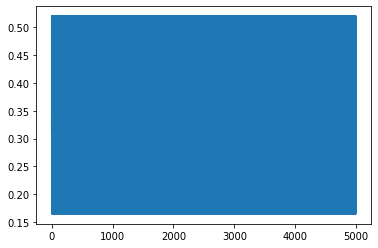

In [0]:
plt.plot(acc)

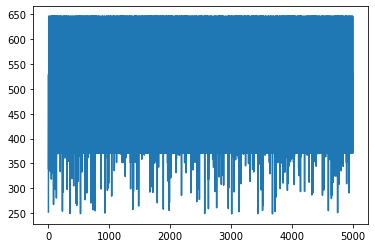

In [0]:
plt.plot(err)

In [0]:
theta_te=np.append(theta_te,[1]*193)
theta_te=theta_te.reshape(51,193)
theta_te.shape

(51, 193)

In [0]:
  z1=np.matmul(weight_mat,theta_te)
  y_pred=softmax(z1)
  preds = np.argmax(y_pred,axis = 0)
  t = np.argmax(Y_te,axis = 0)
  print('The accuracy for test is:',np.sum(preds==t)/len(preds))
  

The accuracy for test is: 0.5440414507772021
